# コード2-2：最小二乗法によるパラメータ推定の実装

『ウイルス感染の数理モデルとシミュレーション ーデータを定量的に理解するー』

このコードでは最小二乗法を用いて数理モデル中のパラメータを推定する例をまとめる。


## ライブラリ、パッケージ（モジュール）の読み込み

- statsmodels https://www.statsmodels.org/
- SciPy https://scipy.org/

In [8]:
## 必要があればインストール
# !pip3 install matplotlib numpy statsmodels scipy

In [9]:
import matplotlib.pyplot as plt ## プロット
import numpy as np
import statsmodels.api as sm
from scipy.optimize import minimize

## データの準備

### 線形のデータ

１次関数で表される式

$$
y \left( t \right) = \beta_{1} t + \beta_{0}
$$

について、$\beta_{0} = 1, \beta_{1} = 2$を真の値とする。

正規分布$\mathcal{N}(0, 1)$に従う乱数を加えたデータを作成し、単純線形回帰で$\beta_{0}, \beta_{1}$を推定する。

In [10]:
## １次関数
def model_linear(t, beta0, beta1):
  return(beta1*t + beta0)

In [11]:
## 真のパラメータの値
beta0_true = 1
beta1_true = 2

t_data_linear = np.array(range(10))

np.random.seed(seed = 30)

y_true_linear = model_linear(t_data_linear, beta0_true, beta1_true)
  
y_data_linear = np.array(y_true_linear) + np.random.normal(loc = 0, scale = 1, size = len(t_data_linear))

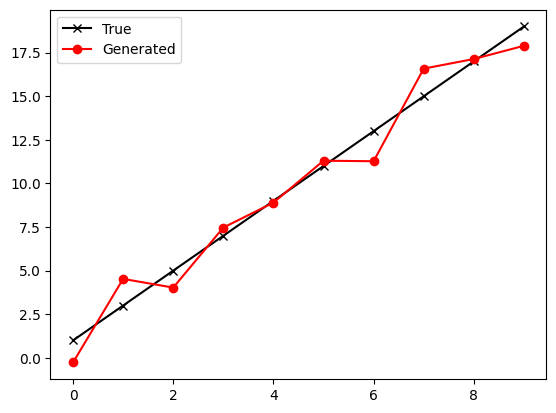

In [12]:
## 生成したデータのプロット
plt.plot(t_data_linear, y_true_linear, marker = "x", color = "black", label = "True")
plt.plot(t_data_linear, y_data_linear, marker = "o", color = "red", label = "Generated")
plt.legend()
plt.show()

### 非線形のデータ

指数関数で表される式

$$
V \left( t \right) = V( 0 ) \exp \left( Gt \right)
$$

について、$V(0) = 10, G = 0.2$を真の値とする。

対数正規分布$\Lambda(0, 1)$に従う乱数を加えたデータを作成し、非線形最小二乗法で$V(0), G$を推定する。

In [13]:
def model_nonlinear(t, v0, g):
  return(v0 * np.exp(g * t))

In [14]:
v0_true = 10
g_true = 0.2

t_data_nonlinear = np.array(range(10))

np.random.seed(seed = 37)

y_true_nonlinear = model_nonlinear(t_data_nonlinear, v0_true, g_true)

y_data_nonlinear = y_true_nonlinear + np.exp(np.random.normal(loc = 0, scale = 1, size = 10))

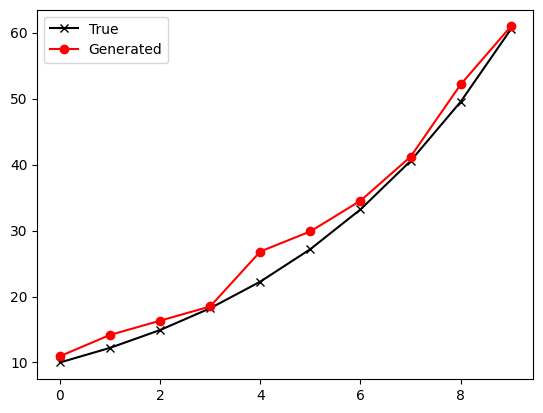

In [15]:
## 生成したデータのプロット
plt.plot(t_data_nonlinear, y_true_nonlinear, marker = "x", color = "black", label = "True")
plt.plot(t_data_nonlinear, y_data_nonlinear, marker = "o", color = "red", label = "Generated")
plt.legend()
plt.show()

## 手計算による単純線形回帰

データ$Y = \left\{ y_1, y_2, \ldots ,y_{n} \right\}$に対して、

$$
\begin{align}
y_i &= y \left( t_i \right) + \varepsilon_i \\
    &= \beta_{1} t_i + \beta_{0} + \varepsilon_i
\end{align}
$$

（$t_i$はデータ$y_i$が観察された時刻、$\varepsilon_i$はデータ$y_i$に対する残差）を考えたときに、残差の二乗和は以下のように表される：

$$
S \left( \beta_0, \beta_1\right) = \sum_{i=1}^{n}{\left(y_i - \beta_{1} t_i - \beta_{0}\right)^2}
$$

$S \left( \beta_0, \beta_1\right)$を最小にするパラメータ$\beta_0, \beta_1$を求めれば良いので、以下の連立方程式

$$
\begin{cases}
\displaystyle \frac{\partial S \left( \beta_0, \beta_1 \right)}{\partial \beta_0} = 0 \\
\displaystyle \frac{\partial S \left( \beta_0, \beta_1 \right)}{\partial \beta_1} = 0
\end{cases}
$$

を解くと、

$$
\beta_0 = \frac{\displaystyle\sum_{i=1}^{n}{{t_i}^2} \sum_{i=1}^{n}{y_i} -
                    \sum_{i=1}^{n}{t_i} \sum_{i=1}^{n}{t_i y_i}}
                {\displaystyle n \sum_{i=1}^{n}{{t_i}^2} - 
                    \left( \sum_{i=1}^{n}{t_i} \right)^2},
\beta_1 = \frac{\displaystyle n \sum_{i=1}^{n}{t_i y_i} -
                    \sum_{i=1}^{n}{t_i} \sum_{i=1}^{n}{y_i}}
                {\displaystyle n \sum_{i=1}^{n}{{t_i}^2} - 
                    \left( \sum_{i=1}^{n}{t_i} \right)^2}
$$

が得られる。

In [16]:
## y_i: y_data_linear[i], t_i: t_data_linear[i]
beta0_est = (np.sum(t_data_linear ** 2) * np.sum(y_data_linear) \
             - np.sum(t_data_linear) * np.sum(t_data_linear * y_data_linear)) \
                / (len(t_data_linear) * np.sum(t_data_linear ** 2) -  np.sum(t_data_linear) ** 2)

beta1_est = (len(t_data_linear) * np.sum(t_data_linear * y_data_linear) \
             - np.sum(t_data_linear) * np.sum(y_data_linear)) \
                / (len(t_data_linear) * np.sum(t_data_linear ** 2) -  np.sum(t_data_linear) ** 2)

In [17]:
## 推定値
print([beta0_est, beta1_est])

[0.932969859725219, 1.9894149622855095]


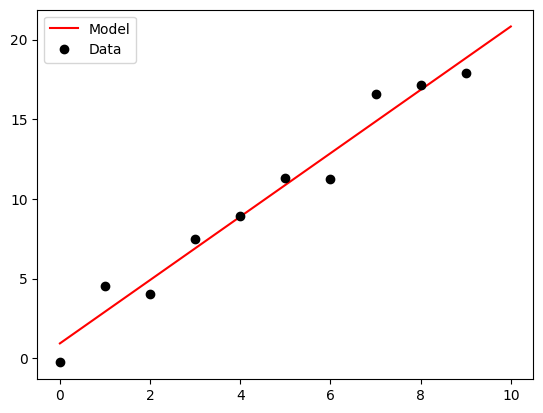

In [18]:
## パラメータの推定値を用いてプロット
stime = np.linspace(0, 10, 100)
plt.plot(stime, model_linear(stime, beta0_est, beta1_est), color = "red", label = "Model")
plt.plot(t_data_linear, y_data_linear, color = "black", marker = "o", linestyle = "none", label = "Data")
plt.legend()
plt.show()

## 単純線形回帰（関数を利用）

ここではstatsmodelsパッケージのOLS関数を用いる。

In [19]:
## 統計モデルの定義
ols_model = sm.OLS(y_data_linear, sm.add_constant(t_data_linear))
## 最小二乗法による線形回帰
res_linear = ols_model.fit()
## 結果の要約の出力
print(res_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     221.5
Date:                Thu, 01 Feb 2024   Prob (F-statistic):           4.09e-07
Time:                        19:20:04   Log-Likelihood:                -15.014
No. Observations:                  10   AIC:                             34.03
Df Residuals:                       8   BIC:                             34.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9330      0.714      1.307      0.2

/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [20]:
## 推定値、手計算で求めた値と同じ
print(res_linear.params)

[0.93296986 1.98941496]


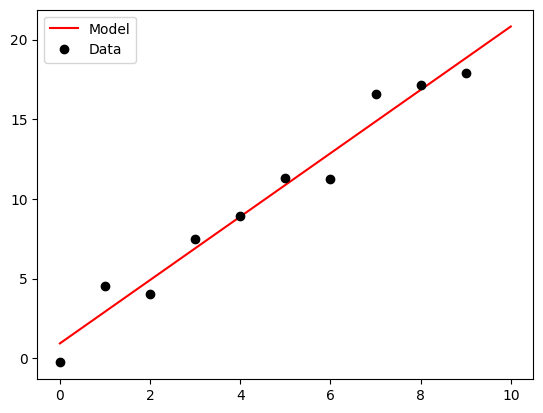

In [21]:
## パラメータの推定値を用いてプロット
stime = np.linspace(0, 10, 100)
plt.plot(stime, model_linear(stime, res_linear.params[0], res_linear.params[1]), color = "red", label = "Model")
plt.plot(t_data_linear, y_data_linear, color = "black", marker = "o", linestyle = "none", label = "Data")
plt.legend()
plt.show()

## 単純線形回帰（最小化アルゴリズムベース）

残差の二乗和を最小にするパラメータの組み合わせを求めれば良いので、以下の関数を最小にする$\beta_0, \beta_1$を数値計算により探索することでパラメータを推定することもできる。

$$
S \left( \beta_0, \beta_1\right) = \sum_{i=1}^{n}{\left(y_i - \beta_{1} t_i - \beta_{0}\right)^2}
$$

ここではSciPyパッケージに含まれるoptimizeモジュールのminimize関数を用いる。

最小化アルゴリズムは"Nelder-Mead"を指定する。

https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html

In [22]:
## 最小化する関数の定義
## ここではtとパラメータ（beta_0, beta_1）を引数として残差の二乗和を返す関数
## beta[0]: beta_0, beta[1]: beta_1
def ls_linear(beta, args):
  return(np.sum((y_data_linear - model_linear(args, beta[0], beta[1])) ** 2))

In [23]:
## 推定初期値（探索を始める最初の値）
beta00 = [3, 1]

np.random.seed(seed = 12)

## Nelder-Mead法によるbeta_0, beta_1の推定
res_linear_op = minimize(fun = ls_linear, x0 = beta00, args = t_data_linear, method = "Nelder-Mead")

In [24]:
## 推定値
## 厳密な解とほぼ同じだが少し違う
print(res_linear_op.x)

[0.9329613  1.98941858]


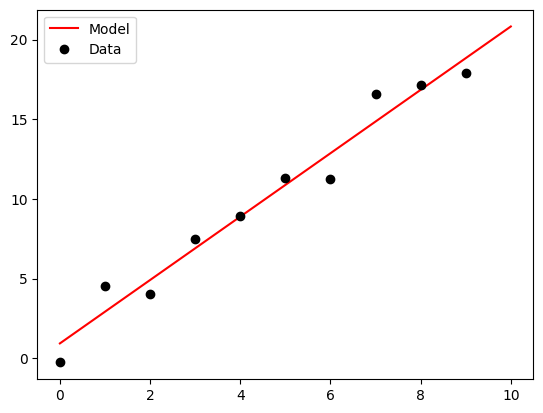

In [25]:
## パラメータの推定値を用いてプロット
stime = np.linspace(0, 10, 100)
plt.plot(stime, model_linear(stime, res_linear_op.x[0], res_linear_op.x[1]), color = "red", label = "Model")
plt.plot(t_data_linear, y_data_linear, color = "black", marker = "o", linestyle = "none", label = "Data")
plt.legend()
plt.show()

## 非線形最小二乗法

説明変数$y_i$と目的変数$t_i$が非線形の関係の場合、つまり

$$
y_i = f(t_i) + \varepsilon_i
$$

で関数$f(t)$が非線形関数である場合は、一般にパラメータを数値計算で推定する。



In [26]:
## 最小化する関数の定義
## ここではtとパラメータ（v(0), G）を引数として残差の二乗和を返す関数
## pars[0]: V(0), pars[1]: G
def ls_nonlinear(pars, args):
  return(np.sum((y_data_nonlinear - model_nonlinear(args, pars[0], pars[1])) ** 2))

In [27]:
## 推定初期値（探索を始める最初の値）
pars00 = [20, 1]

## Nelder-Mead法によるV(0), Gの推定
res_nonlinear_op = minimize(fun = ls_nonlinear, x0 = pars00, args = t_data_nonlinear, method = "Nelder-Mead")

In [28]:
## 推定値
print(res_nonlinear_op.x)

[11.55156494  0.18555376]


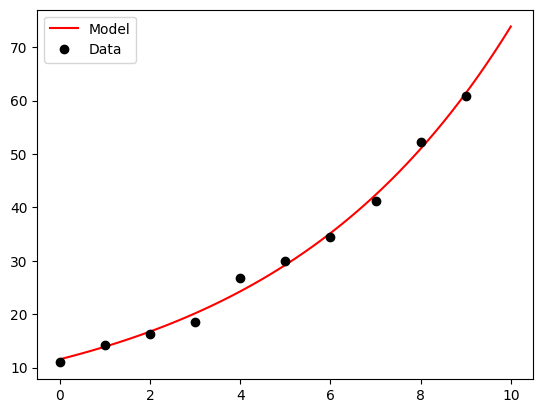

In [29]:
## パラメータの推定値を用いてプロット
stime = np.linspace(0, 10, 100)
plt.plot(stime, model_nonlinear(stime, res_nonlinear_op.x[0], res_nonlinear_op.x[1]), color = "red", label = "Model")
plt.plot(t_data_nonlinear, y_data_nonlinear, color = "black", marker = "o", linestyle = "none", label = "Data")
plt.legend()
plt.show()

※ 式（2.5）のように対数変換をすることで、対数正規分布で与えた誤差が正規分布となるので、正確な推定ができる。